# Configurer votre colab pour le calcul sur GPU
Dans le menu au dessus, choisir le sous-menu **Exécution** puis l'option **Modifier le type d'exécution**. 

Une fenêtre apparaît où vous pouvez choisir un accélérateur matériel. Choisissez un *GPU* puis *enregistrer* votre choix.

Afin de vérifier que vous avez bien configuré votre session pour utiliser un GPU, exécuter le code ci-dessous (en passant la souris, une petite flèche pour l'exécuter apparaît).

Si tout se passe bien, un tableau (en ascii) apparaît avec le type de carte (et son architecture) auquel vous avez accès. Si un message d'erreur apparaît, vérifiez dans **Modifier le type d'exécution** que l'accélérateur matériel est bien configuré pour un *GPU*

In [1]:
!nvidia-smi

Mon Feb 20 21:54:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installation de PyCuda

Pour utiliser le GPU sous Python il faut soit installer **PyCuda** pour effectuer des calculs, soit **PyTorch** pour effectuer du machine learning accéléré par les GPUs.

Dans ce TP, nous nous bornerons uniquement à effectuer des calculs sur GPU !

Pour cela, il faut d'abord installer pyCuda et donc exécuter le code ci-dessous (toujours en appuyant sur la flèche pour exécuter le code, et attendez, cela prend un petit moment...)

In [2]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp38-cp38-linux_x86_64.whl size=662008 sha256=142528d6fb4811a3859005e6b0ef4cbfbbaed024244a8eb88be40dccc6f1e9df
  Stored in directory: /root/.cache/pip/wheels/7b/41/0d/7cecb04af969d283ebe4a69579a8b2baec0d010a1ac4159f7e
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69870 sha256=05510df86b3fef3c187b1c15c1875cb10015909ed3505fcb1dcde872855f8ac9
  Stored in directory: /root/.cache/pip/wheels/cb/fc/a

# Vérification du bon fonctionnement du module PyCuda

Afin de vérifier le bon fonctionnement de l'installation, nous allons écrire un script Cuda qui servira en même temps d'exemple pour le TP d'aujourd'hui. Ce script sera scindé en plusieurs morceaux et commenté pour que vous compreniez chaque partie du code.

Ce code sera très simple : on va créer une matrice 4x4 avec des données prises "au hasard" (mais avec une graine aléatoire fixée, donc...) , recopier ce tableau dans la mémoire de la carte graphique et demander à la carte graphique de doubler la valeur de chaque élément de la matrice puis de recopier dans la mémoire de l'ordinateur les valeurs calculées. On affiche ensuite la matrice initiale et la matrice transformée.

Dans un premier temps, chargeons les modules python nécessaire à l'exécution d'un noyau Cuda (**Remarque** : l'importation de ces modules n'est nécessaire qu'une seule fois pour **TOUTE** la session. Il sera donc inutile de reimporter ces modules dans le reste du TD !) :

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Créons à l'aide de numpy un tableau *a* dont les valeurs aléatoires sont issues d'une graine fixée :

In [4]:
import numpy
numpy.random.seed(1729)

Puisque certaines cartes graphiques supportent mal le double précision, nous allons demander à Python que les éléments de *a* soient en simple précision :

In [5]:
a = numpy.random.randn(4,4) # Sous forme de matrice 4 x 4
a = a.astype(numpy.float32)
print(a.nbytes)
print(a)

64
[[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]


Nous allons ensuite allouer de la place mémoire sur la mémoire vive du GPU. Comme en C, la place mémoire est exprimée en *Octets* :

In [6]:
a_gpu = cuda.mem_alloc(a.nbytes)

Une fois la réservation sur le GPU de faite, on recopie les valeurs de *a* dans le tableau *a_gpu* que l'on vient de réserver (htod signifie host **to** device):

In [7]:
cuda.memcpy_htod(a_gpu, a)

Il faut ensuite écrire le noyau qui s'exécutera sur la carte graphique à l'aide du langage CUDA (qui est une extension du langage C).

**Remarquez** dans le code qu'on s'assure que les indices donnés par les numéros de threads ne dépassent pas la dimension de la matrice !

In [8]:
mod = SourceModule("""
__global__ void doublify( int dim_x, int dim_y, float *a )
{
  if ((threadIdx.x < dim_x) && (threadIdx.y < dim_y))
  {
    int idx = threadIdx.x + threadIdx.y * dim_x;
    a[idx] *= 2;
  }
}
""")

Nous allons récupérer ensuite un "handle" sur le noyau cuda que l'on vient de créer (en invoquant le nom de la fonction) et l'invoquer sur la carte graphique en dimensionnant la grille de calcul à l'aide de *block=(4,4,1)* (et en l'adaptant aux dimensions de la matrice).

Ici, nous n'avons pas besoin de configurer de grilles car la dimension de la matrice *a* est petite, mais comme la taille d'un bloc dans une direction est limitée à 256, pour des cas plus gros, il faudra également passer une grille en paramètre à l'aide de *grid=(x,y,z)* où *x,y* et *z* sont des valeurs entières positives et utiliser dans le noyau cuda les valeurs *x,y* et *z* de **blockIdx** et **blockDim**.

**REMARQUE IMPORTANTE** : Le noyau cuda ne veut que des types C basiques en argument. Or un entier python est tout sauf un type basique du C. Donc pour passer un argument entier à un noyau cuda, il faut créer un entier 32 bits à l'aide de numpy.int32

In [9]:
func = mod.get_function("doublify")
dim = numpy.int32(4)
func(dim, dim, a_gpu, block=(4,4,1))

Il ne reste plus qu'à récupérer les nouvelles valeurs de la matrice en transférant les données de la matrice contenue par le GPU dans un tableau numpy se trouvant dans la RAM de l'ordinateur (dtoh signifie device **to** host) :

In [10]:
a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

Il ne reste plus qu'à afficher la matrice initiale puis la matrice obtenue par le calcul sur GPU :

In [11]:
print(f"a : {a}")
print(f"a_gpu : {a_doubled}")

a : [[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]
a_gpu : [[-1.3746789  -1.6419895   3.3047218  -1.1505861 ]
 [ 2.1979356   1.8518921  -1.9868276  -1.7164422 ]
 [ 0.14977352  1.058711    0.2419031  -0.44884723]
 [-3.113357    0.11188176  0.32294306 -4.2692833 ]]


## Exercices de mises en bouche

En vous inspirant du programme commenté ci-dessus, écrivez un code avec un noyau Cuda qui fait la somme de deux vecteurs de réels simples précisions et qui range le résultat dans un troisième vecteur. 

On s'exercera à utiliser des vecteurs de "grandes" dimensions (> 256) afin de s'entrainer à calculer des indices globaux dans le noyau cuda à l'aide de *threadIdx.x*, *blockIdx.x* et *dimBlock.x*.

Ecrivez (ou copier coller) votre code dans la cellule ci-dessous

In [12]:
n = 300
vec1 = numpy.random.randn(n) # Sous forme de vecteur 4
vec1 = vec1.astype(numpy.float32)
vec1_gpu = cuda.mem_alloc(vec1.nbytes)
cuda.memcpy_htod(vec1_gpu, vec1)

vec2 = numpy.random.randn(n) # Sous forme de vecteur 4
vec2 = vec2.astype(numpy.float32)
vec2_gpu = cuda.mem_alloc(vec2.nbytes)
cuda.memcpy_htod(vec2_gpu, vec2)


In [13]:
mod = SourceModule("""
__global__ void sum( int dim_x, float *vec1, float *vec2 )
{
  if ((threadIdx.x < dim_x))
  {
    int idx = threadIdx.x;
    vec1[idx] = vec1[idx] + vec2[idx];
  }
}
""")

In [14]:
func = mod.get_function("sum")
dim = numpy.int32(n)
func(dim, vec1_gpu, vec2_gpu, block=(4,1,1))

In [15]:
vec1_doubled = numpy.empty_like(vec1)
cuda.memcpy_dtoh(vec1_doubled, vec1_gpu)

/usr/local/lib/python3.8/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


In [16]:
print(f"vect1 : {vec1}")
print(f"vec1_gpu : {vec1_doubled}")

vect1 : [ 1.09670043e-01  4.43012148e-01  3.96266222e-01  2.49797404e-01
  1.29849732e+00 -1.28043365e+00 -9.75465834e-01 -2.69086629e-01
 -1.10573840e+00 -1.27992705e-01 -6.17827356e-01 -9.89126265e-01
 -2.85989237e+00 -7.94347525e-01 -3.05796951e-01  1.70063758e+00
 -6.35444164e-01  4.57386579e-03  1.13330400e+00  1.41641274e-01
  2.09171796e+00 -1.26955926e+00 -7.22823381e-01 -1.93888936e-02
 -1.82823569e-01 -1.11906576e+00 -6.98275089e-01  2.10708451e+00
 -2.55559874e-03  4.09010053e-01  2.83636749e-01 -1.94985449e+00
  3.86030883e-01  2.30641112e-01 -1.18697083e+00 -6.66551590e-01
  1.79776692e+00  6.63798332e-01  1.12381160e+00 -1.13430619e+00
  1.18444979e+00  7.01262355e-01  4.55496371e-01 -8.14868957e-02
 -1.09586859e+00  4.40716892e-01  1.64270854e+00  4.47959393e-01
 -7.86716700e-01 -1.73142985e-01  2.31948209e+00 -3.28604549e-01
 -2.38856971e-01 -2.16715157e-01  9.87426937e-01  1.80691957e+00
 -5.64313769e-01  5.43536484e-01  5.42878568e-01  2.07137957e-01
 -2.31273577e-01 

Une fois le code mis au point, recopiez le ci-dessous et adaptez le pour additionner deux matrices carrées dans une troisième.

In [17]:
new_mod = SourceModule("""
__global__ void sum_mat(int dim_x,int dim_y, float **vec1, float **vec2, float **vec3)
{
  if ((threadIdx.x < dim_x) && (threadIdx.y < dim_y))
  {
    int idx = threadIdx.x;
    int idy = threadIdx.y;
    vec3[idx][idy] = vec1[idx][idy] + vec2[idx][idy];
  }
}
""")

In [18]:
mat1 = numpy.random.randn(n,n) # Sous forme de vecteur 4
mat1 = mat1.astype(numpy.float32)
mat1_gpu = cuda.mem_alloc(mat1.nbytes)
cuda.memcpy_htod(mat1_gpu, mat1)

mat2 = numpy.random.randn(n,n) # Sous forme de vecteur 4
mat2 = mat2.astype(numpy.float32)
mat2_gpu = cuda.mem_alloc(mat2.nbytes)
cuda.memcpy_htod(mat2_gpu, mat2)


In [19]:
mat3 = numpy.random.randn(n,n) # Sous forme de vecteur 4
mat3 = mat3.astype(numpy.float32)
mat3_gpu = cuda.mem_alloc(mat3.nbytes)
cuda.memcpy_htod(mat3_gpu, mat3)

func_mat_sum = new_mod.get_function("sum_mat")
dim = numpy.int32(4)
func(dim, dim, mat1_gpu, mat2_gpu, mat3_gpu, block=(4,1,1))

In [20]:
cuda.memcpy_dtoh(mat3, mat3_gpu)
print(f"vec1_gpu : {mat1}")
print(f"vec1_gpu : {mat2}")
print(f"vec1_gpu : {mat3}")

vec1_gpu : [[-1.6318041  -0.43748724  1.5358901  ...  0.72045714 -0.78287977
  -1.0631311 ]
 [-0.82010895 -0.59591895  0.73305225 ...  0.08176677 -0.7228375
   0.7914526 ]
 [-0.41279322 -0.76022553 -1.1476926  ... -0.7564423  -1.1226166
  -0.188138  ]
 ...
 [ 0.58627653 -0.3140901  -0.8232617  ...  0.5871866  -1.1038766
   0.3518926 ]
 [-0.13144387  0.25668687 -0.20578636 ...  1.3556963   0.3782966
   0.9252573 ]
 [-1.2687932  -0.915642    1.0990869  ... -0.13402025 -0.8900148
  -0.46008185]]
vec1_gpu : [[ 0.36297935  0.91218     0.63539904 ... -0.9504657  -0.1529945
   1.5564573 ]
 [ 0.9306962  -0.01202123  0.76751    ...  0.67072654 -0.1729073
  -0.57277375]
 [-0.5366881   0.8787357   0.5604448  ... -2.051202   -1.9522129
  -0.4379339 ]
 ...
 [-1.3038667   0.6264965   0.8735167  ...  0.38807017 -0.299226
   0.75357413]
 [ 0.928567    0.8567112   1.0437129  ... -1.0563341   0.20493966
  -0.9141263 ]
 [ 0.7422784  -1.1625295   0.5264803  ...  1.1183426   1.1924585
   0.31526554]]
vec1_

# Exercice final

Nous allons de nouveau nous intéresser à l'ensemble de Mandelbrot. La cellule ci-dessous contient un code permettant de calculer à l'aide de numpy un ensemble de mandelbrot (le code est simplifié par rapport aux codes sur CPU pour faciliter le TP même si il utilise la notation vectorielle de numpy (il faudra y faire attention pour code le noyau cuda !) : code repris de https://stackoverflow.com/questions/60467316/displaying-mandelbrot-set-in-python-using-matplotlib-pyplot-and-numpy).

Transformez le de sorte que sur GPU, chaque thread calcule un pixel de l'image de destination.

<ipython-input-21-127f5f7520b6>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ones = np.ones(np.shape(c), np.int)
<ipython-input-21-127f5f7520b6>:18: RuntimeWarning: overflow encountered in square
  z = z**2 + c
<ipython-input-21-127f5f7520b6>:18: RuntimeWarning: invalid value encountered in square
  z = z**2 + c
<ipython-input-21-127f5f7520b6>:19: RuntimeWarning: overflow encountered in absolute
  diverged = np.abs(z)>2


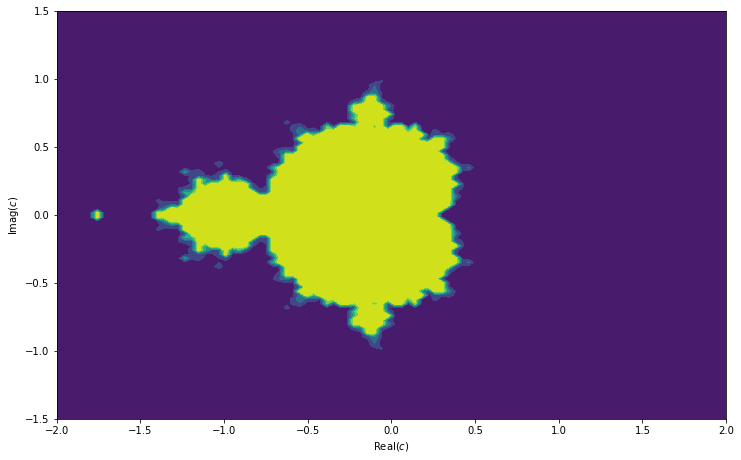

In [21]:
import pylab as plt
import numpy as np
# initial values 
loop = 100 # number of interations
div = 100 # divisions
# all possible values of c
c = np.linspace(-2,2,div)[:,np.newaxis] + 1j*np.linspace(-1.5,1.5,div)[np.newaxis,:]
# array of ones of same dimensions as c
ones = np.ones(np.shape(c), np.int)
# Array that will hold colors for plot, initial value set here will be
# the color of the points in the mandelbrot set, i.e. where the series
# converges.
# For the code below to work, this initial value must at least be 'loop'.
# Here it is loop + 5
color = ones * loop + 5
z = 0
for n in range(0,loop):
      z = z**2 + c
      diverged = np.abs(z)>2
      # Store value of n at which series was detected to diverge.
      # The later the series is detected to diverge, the higher
      # the 'color' value.
      color[diverged] = np.minimum(color[diverged], ones[diverged]*n)

plt.rcParams['figure.figsize'] = [12, 7.5]
# contour plot with real and imaginary parts of c as axes
# and colored according to 'color'
plt.contourf(c.real, c.imag, color)
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.xlim(-2,2)
plt.ylim(-1.5,1.5)
plt.savefig("plot.png")
plt.show()

In [22]:
from __future__ import print_function, division, absolute_import
import numpy as np
from matplotlib.pylab import imshow, show
from numba import cuda

In [27]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cpp-8 fonts-dejavu-core fonts-dejavu-extra g++-8 gcc-8 gcc-8-base
  javascript-common libaccinj64-10.1 libatk-wrapper-java
  libatk-wrapper-java-jni libcublas10 libcublaslt10 libcudart10.1 libcufft10
  libcufftw10 libcuinj64-10.1 libcupti-dev libcupti-doc libcupti10.1
  libcurand10 libcusolver10 libcusolvermg10 libcusparse10 libgail-common
  libgail18 libgcc-8-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libjs-jquery libjs-underscore libmpx2 libncurses5 libnppc10 libnppial10
  libnppicc10 libnppicom10 libnppidei10 libnppif10 libnppig10 libnppim10
  libnppist10 libnppisu10 libnppitc10 libnpps10 libnvblas10 libnvgraph10
  libnvidia-ml-dev libnvjpeg10 libnvrtc10.1 libnvtoolsext1 libnvvm3
  libstdc++-8-de

In [34]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"


In [35]:
#decorator to function definition to make it a CUDA kernel
@cuda.jit
def mandelbrot_gpu(mat, maxiter=100, xmin=-2.6, xmax=1.85, ymin=-1.25, ymax=1.25):
    x = cuda.blockIdx.x
    y = cuda.threadIdx.x
    
    # Mapping pixel to C
    creal = xmin + x / mat.shape[0] * (xmax - xmin)
    cim = ymin + y / mat.shape[1] * (ymax - ymin)
    
    # Initialisation of C and Z
    c = complex(creal, cim)
    z = complex(0, 0)
    
    # Mandelbrot iteration
    for n in range(maxiter):
        z = z*z+c
        # If unbounded: save iteration count and break
        if z.real*z.real + z.imag*z.imag > 4.0:
            # Smooth iteration count
            mat[x,y] = n + 1 - math.log(math.log(abs(z*z+c)))/math.log(2)
            break
        # Otherwise: leave it to 0


In [36]:
#function to draw image
def draw_image(mat, cmap='inferno', powern=0.5, dpi=72):
    ## Value normalization
    # Apply power normalization, because number of iteration is 
    # distributed according to a power law (fewer pixels have 
    # higher iteration number)
    mat = np.power(mat, powern)
    
    # Colormap: set the color the black for values under vmin (inner points of
    # the set), vmin will be set in the imshow function
    new_cmap = copy.copy(cm.get_cmap(cmap))
    new_cmap.set_under('black')
    
    ## Plotting image
    
    # Figure size
    plt.figure(figsize=(mat.shape[0]/dpi, mat.shape[1]/dpi))
    
    # Plotting mat with cmap
    # vmin=1 because smooth iteration count is always > 1
    # We need to transpose mat because images use row-major
    # ordering (C convention)
    # origin='lower' because mat[0,0] is the lower left pixel
    plt.imshow(mat.T, cmap=new_cmap, vmin=1, origin = 'lower')
    
    # Remove axis and margins
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')

/usr/local/lib/python3.8/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


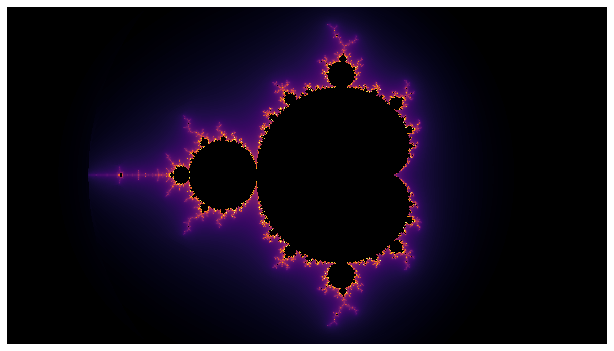

In [38]:
pycuda.driver.init()
pycuda.driver.Device(0).retain_primary_context()

import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
%matplotlib inline
import math

# Parameters
xmin, xmax = -2.6, 1.85
ymin, ymax = -1.25, 1.25
xpixels = 600
ypixels = round(xpixels / (xmax-xmin) * (ymax-ymin))

maxiter = 100
mat = np.zeros((xpixels, ypixels))

# Running and plotting result
mandelbrot_gpu[xpixels, ypixels](mat, maxiter, xmin, xmax, ymin, ymax)
draw_image(mat)